# 实验一：语音特征提取

## 加载音频文件

In [23]:
import math
import tqdm
import librosa
import librosa.display as ldis
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from voice_changer.utils import *

In [24]:
# FFT 步长
N_FFT = 512
# 窗长
WIN_LENGTH = N_FFT
# 帧长
HOP_LENGTH = N_FFT // 4
# 加窗类型
WINDOW = "cosine"
# 音量增益
POWER = 2.0

fft_cfg = {
    "n_fft": N_FFT,
    "win_length": WIN_LENGTH,
    "hop_length": HOP_LENGTH,
    "window": WINDOW,
}


In [25]:
y, sr = load_sound(r"./data/test/aiueo.aac")
y *= POWER
sf = librosa.stft(y, **fft_cfg)
nsf = np.abs(sf)
print(f"{y.shape=}\n{nsf.shape=}")

y.shape=(80439,)
nsf.shape=(257, 629)


In [26]:
play_sound(y, sr)

## 语谱图

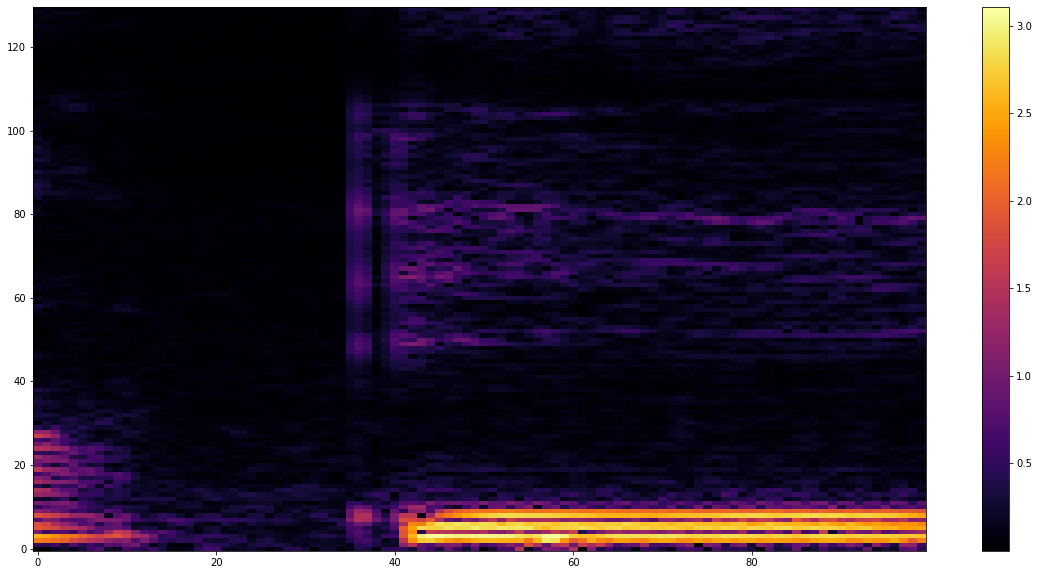

In [27]:
# 语谱图
nsf_db = np.log(nsf + 1)[:, 180:280]
plt.figure(figsize=(20, 10))
plt.imshow(nsf_db[:130, :], aspect="auto", origin="lower", cmap="inferno")
plt.colorbar()
plt.savefig("pitch.eps", format="eps")
plt.show()


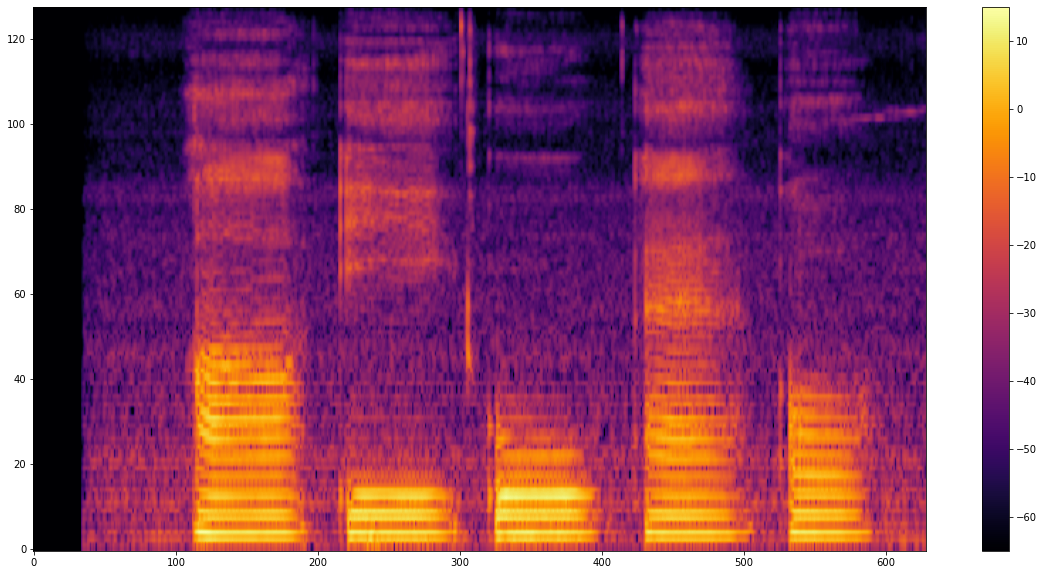

In [28]:
# Mel 响度语谱图
sf_mel = librosa.feature.melspectrogram(y=y, sr=sr, **fft_cfg, n_mels=128)
sf_mel_db = librosa.power_to_db(sf_mel)
plt.figure(figsize=(20, 10))
plt.imshow(sf_mel_db, aspect="auto", origin="lower", cmap="inferno")
plt.colorbar()
plt.show()

在 STFT 得到的语谱图中，频率表现为一定宽度的条带，这是因为 STFT 得到的频率是一个离散的值，而不是一个连续的函数，而真实的频率往往落在离散值之外。
根据三角函数公式：$\cos(\alpha+\beta)+\cos(\alpha-\beta) = 2\cos\alpha\cos\beta$（假设$\alpha >> \beta$），可知相近频率的波形之和可以表现为一个中间频率的波形（$\cos\alpha$）在长时段的波动（$\cos\beta$），而由于 STFT 的窗口较小，后者可以近似为常数，因此对于离散值之外的频率，在语谱图上的表现就是一系列在真实频率附近分布的能量相近的条带。

## 语音重建

In [29]:
# 语音重建（带相位）
y_recon = librosa.istft(sf, **fft_cfg)
play_sound(y_recon, sr)

In [30]:
# 语音重建（无相位，griffin-lim 算法）
iter_num = 200
phase = np.exp(2j * np.pi * np.random.randn(*sf.shape))
nsf_complex = nsf.astype(np.complex64)
for _ in tqdm.trange(iter_num):
    sf_recon = nsf_complex * phase
    y_recon = librosa.istft(sf_recon, **fft_cfg)
    phase = np.exp(1j * np.angle(librosa.stft(y_recon, **fft_cfg)))
play_sound(y_recon, sr)

100%|██████████| 200/200 [00:07<00:00, 27.52it/s]


In [32]:
# 语音重建（无相位，librosa 的 griffin-lim 算法）
y_recon = librosa.griffinlim(nsf, **fft_cfg)
play_sound(y_recon, sr)

在语音处理之后，往往 STFT 得到的相位信息会丢失，此时需要用一定的算法找回相位信息，以重建语音采样。

Griffin-Lim 算法：
1. 初始化相位的估计值为随机数。
2. 利用相位的估计值和频率强度的已知值，进行 STFT 逆变换，得到估计的语音信号。
3. 将估计的语音信号再次进行 STFT 变换，得到新的一组频率强度和相位。
4. 丢弃上一步获得的频率强度，使用真实的频率强度和相位，回到第2步，进行下一轮迭代。
5. 迭代一定次数后停止。此时的估计值为最终的相位。

`librosa` 提供了 Griffin-Lim 算法的快速计算方式。

## 变速与变调

In [ ]:
# 重采样
K = 1.5
y_down = librosa.resample(y, orig_sr=sr, target_sr=sr / K)
print(f"{y.shape=}\n{y_down.shape=}")
play_sound(y_down, sr)  # 以原本的 sr 播放，达到变速的效果

y.shape=(80439,)
y_down.shape=(53626,)


In [ ]:
# 语音变速（频域重采样）
K = 1.5
nsf_down = librosa.resample(nsf, orig_sr=10000, target_sr=10000 * K)
y_recon = librosa.griffinlim(nsf_down, **fft_cfg)
play_sound(y_recon, sr)

In [ ]:
# 语音变速（带相位的频域重采样）
sf_down_real = librosa.resample(np.real(sf), orig_sr=sr, target_sr=sr * 1.5)
sf_down_imag = librosa.resample(np.imag(sf), orig_sr=sr, target_sr=sr * 1.5)
sf_down = sf_down_real + 1j * sf_down_imag
y_recon = librosa.istft(sf_down, **fft_cfg)
play_sound(y_recon, sr)  # 相位信息的错位导致声音有明显的机械感

In [ ]:
# 验证：相位错误导致机械感
y_recon = librosa.istft(nsf.astype(np.complex64), **fft_cfg)
play_sound(y_recon * 5, sr)

In [ ]:
# 简单变调：时域重采样+频域重采样
K = 1.5
y_down = librosa.resample(y, orig_sr=10000 * K, target_sr=10000)
sf_down = librosa.stft(y_down, **fft_cfg)
nsf_down = librosa.resample(np.abs(sf_down), orig_sr=10000, target_sr=10000 * K)
y_recon = librosa.griffinlim(nsf_down, **fft_cfg)
play_sound(y_recon, sr)

In [ ]:
# 相位声像器
K = 2.0
sf_coef = librosa.phase_vocoder(sf, rate=K, hop_length=HOP_LENGTH)
y_recon = librosa.istft(sf_coef, **fft_cfg)
play_sound(y_recon, sr)

In [ ]:
# 变调：时域重采样+相位声像器
K = 1.5
y_down = librosa.resample(y, orig_sr=10000 * K, target_sr=10000)
sf_down = librosa.stft(y_down, **fft_cfg)
sf_coef = librosa.phase_vocoder(sf_down, rate=1 / K, hop_length=HOP_LENGTH)
y_recon = librosa.istft(sf_coef, **fft_cfg)
play_sound(y_recon * 2, sr)

## 特征提取

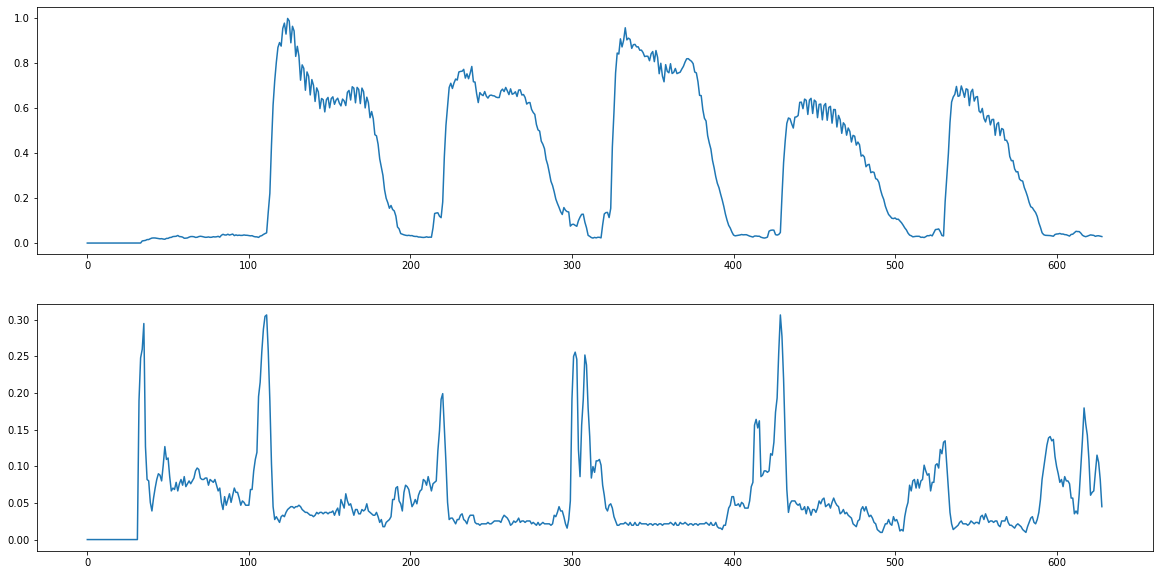

In [ ]:
# 相对音量和过零率
volume = librosa.feature.rms(y=y, frame_length=WIN_LENGTH, hop_length=HOP_LENGTH).reshape(-1)
volume /= volume.max()
zero_cross = librosa.feature.zero_crossing_rate(y, frame_length=WIN_LENGTH, hop_length=HOP_LENGTH).reshape(-1)
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(volume)
plt.subplot(2, 1, 2)
plt.plot(zero_cross)
plt.show()

过零率高且音量高的地方是清辅音，过零率低但音量高的地方是浊音或元音。

### 寻找基频

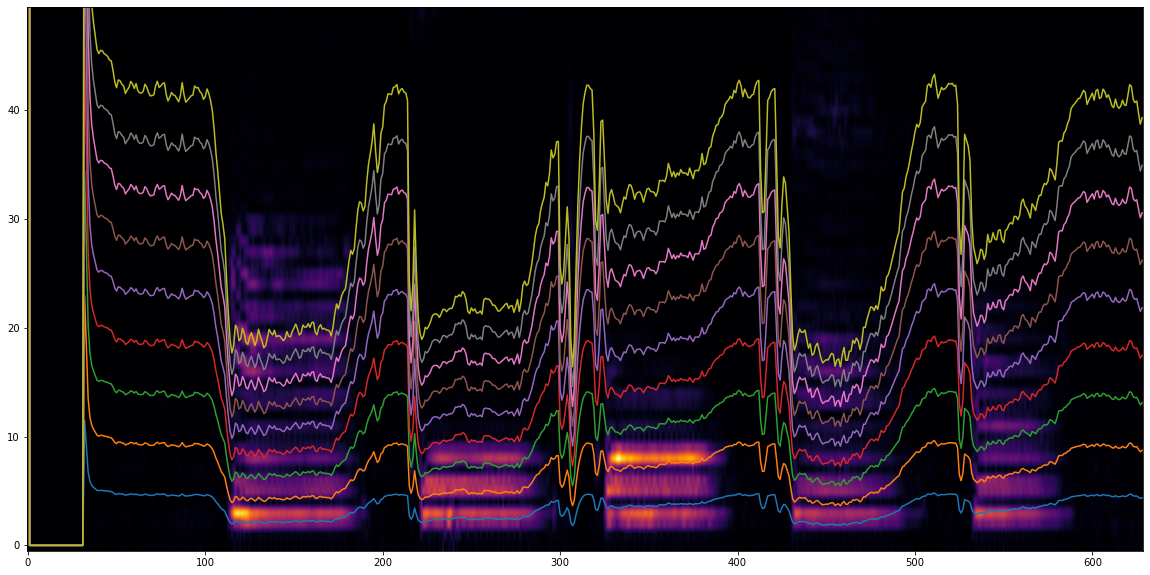

In [33]:
# 寻找基频：倒谱分析法
nsf_log = np.log(nsf, where=nsf > 0)
nsf_inv = np.abs(np.fft.ifft(nsf_log.T))[:, 0]
# nsf_inv[volume < 0.2] = np.nan  # 过滤掉非语音段
# nsf_inv[zero_cross > 0.3] = np.nan  # 过滤掉清音
plt.figure(figsize=(20, 10))
plt.margins(0, 0.1)
for i in range(1, 10):  # 绘制谐波，和共振峰比较
    plt.plot(nsf_inv * i)
plt.imshow(nsf[:50, :], aspect="auto", origin="lower", cmap="inferno")
plt.savefig("report/pdf/assets/nsf_inv.eps")
plt.show()


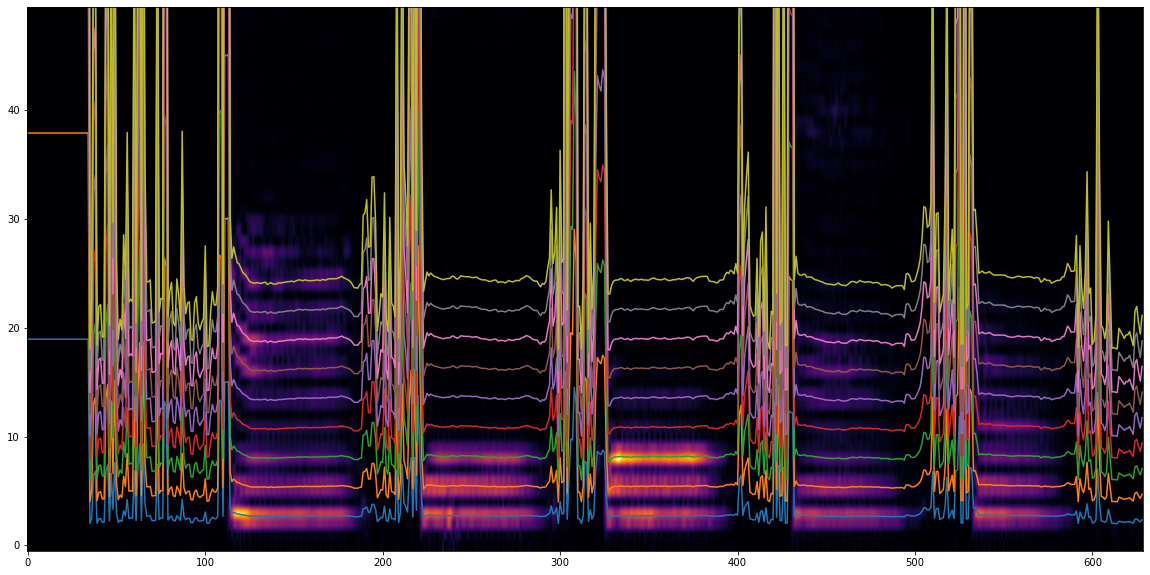

In [34]:
# 寻找基频：YIN 算法
f0_yin = librosa.yin(y, sr=sr, fmin=80, fmax=800, frame_length=WIN_LENGTH, hop_length=HOP_LENGTH)
# f0_yin[volume < 0.2] = np.nan
# f0_yin[zero_cross > 0.3] = np.nan  # 过滤掉清音
plt.figure(figsize=(20, 10))
plt.margins(0, 0.1)
for i in range(1, 10): # 绘制谐波，和共振峰比较
    plt.plot(f0_yin * N_FFT / sr * i)
plt.imshow(nsf[:50, :], aspect="auto", origin="lower", cmap="inferno")
plt.savefig("report/pdf/assets/f0_yin.eps")
plt.show()

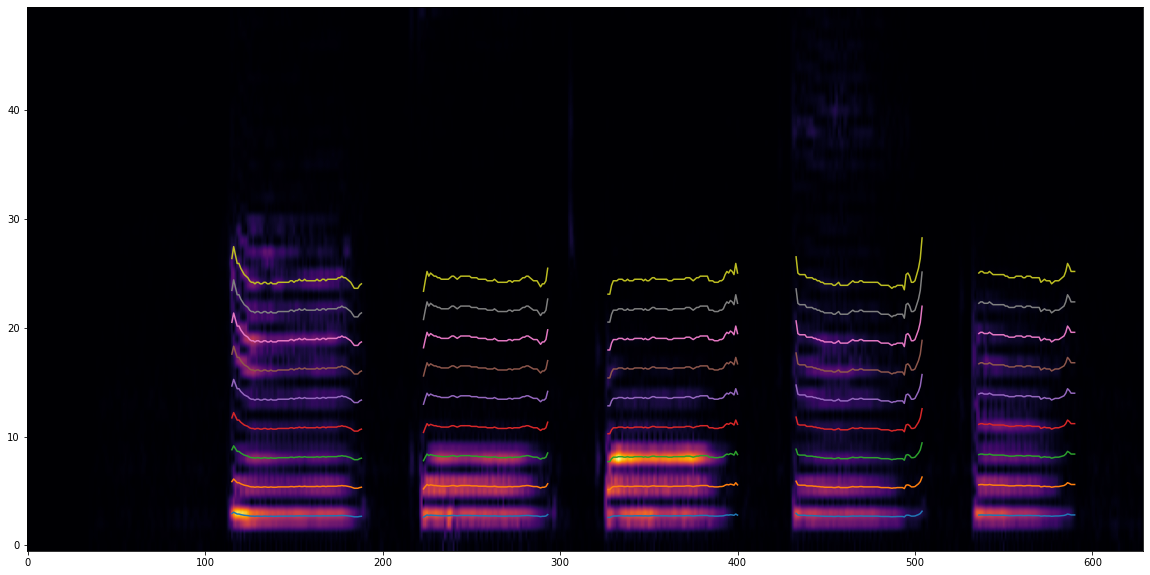

In [35]:
# 寻找基频：概率 YIN 算法
f0, vf, vp = librosa.pyin(y, sr=sr, fmin=80, fmax=800, frame_length=WIN_LENGTH, hop_length=HOP_LENGTH)
plt.figure(figsize=(20, 10))
plt.margins(0, 0.1)
for i in range(1, 10): # 绘制谐波，和共振峰比较
    plt.plot(f0 * N_FFT / sr * i)
plt.imshow(nsf[:50, :], aspect="auto", origin="lower", cmap="inferno")
plt.savefig("report/pdf/assets/f0_yin_prob.eps")
plt.show()

三种基频寻找算法比较：
1. 倒谱分析速度最快，但结果最不准确。
2. 原始 YIN 算法速度较快，结果也相对准确，但在语音边界有很大的误差。
3. pYIN 算法速度很慢，但结果最准确，并且可以区分语音边界。

### 频域特性

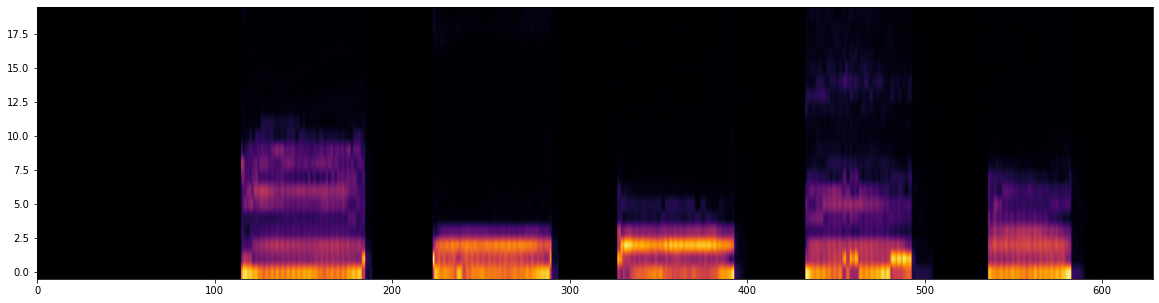

In [ ]:
# 频域特性（共振峰相对能量）
NH = 20  # 谐波数量
fq_fea = np.zeros((NH, sf.shape[1]), dtype=np.float32)
for i in range(1, NH + 1):
    freq_l = np.floor(f0 * N_FFT / sr * (i - 0.5)).astype(np.int32)
    freq_h = np.floor(f0 * N_FFT / sr * (i + 0.5)).astype(np.int32)
    for j in range(sf.shape[1]):
        fq_fea[i - 1, j] = np.sqrt(np.sum(nsf[freq_l[j] : freq_h[j], j] ** 2))
np.nan_to_num(fq_fea, copy=False)
np.divide(fq_fea, volume, out=fq_fea, where=volume > 0.2)  # 去除音量的影响
fq_fea /= fq_fea.max()  # 归一化
plt.figure(figsize=(20, 5))
plt.imshow(fq_fea, aspect="auto", origin="lower", cmap="inferno")
plt.show()


In [ ]:
# 基于频域特性重建正弦音频
nsf_recon = np.zeros(nsf.shape, dtype=np.float32)
for i in range(1, NH + 1):
    freq = f0 * N_FFT / sr * i
    freq_l = np.floor(freq).astype(np.int32)
    freq_l[freq_l >= N_FFT] = N_FFT - 1
    freq_l[freq_l < 0] = 0
    for j, fq in enumerate(freq_l):
        nsf_recon[fq, j] += fq_fea[i - 1, j] * volume[j] * 50
np.nan_to_num(nsf_recon, copy=False)
y_recon = librosa.griffinlim(nsf_recon, **fft_cfg)
play_sound(y_recon, sr)


### MFCC 特征

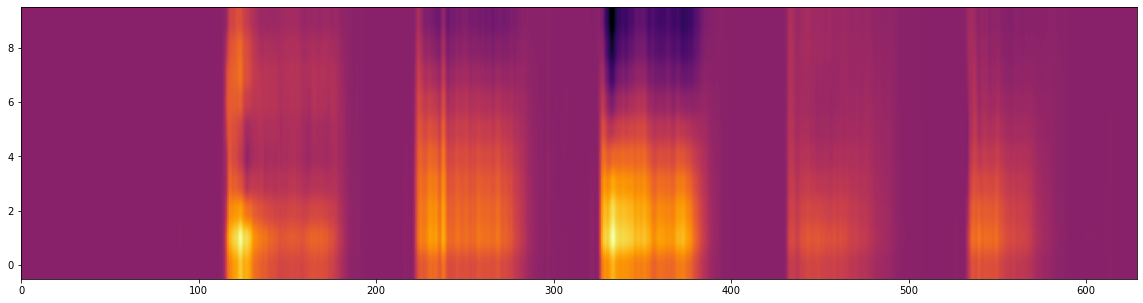

In [ ]:
mfcc = librosa.feature.mfcc(S=sf_mel, n_mfcc=10)
plt.figure(figsize=(20, 5))
plt.imshow(mfcc, aspect="auto", origin="lower", cmap="inferno")
plt.show()